# Rakuten Image Classification - ResNet50 Training

## 1. Configuration

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import json
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from torch.cuda.amp import GradScaler
import wandb

project_root = Path.cwd().parent.parent
scripts_dir = project_root / "scripts"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

from src.rakuten_image.datasets import RakutenImageDataset
from src.rakuten_image.models import ResNet50Classifier
from load_data import split_data

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

wandb.login()

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti
VRAM: 8.36 GB


wandb: Currently logged in as: xiaosong-dev (xiaosong-dev-formation-data-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
CONFIG = {
    "data_dir": Path("/workspace/data"),
    "img_dir": Path("/workspace/data/images/image_train"),
    "checkpoint_dir": Path("/workspace/checkpoints/resnet50_production"),

    "img_size": 224,
    "batch_size": 64,
    "num_epochs": 30,
    "learning_rate": 2e-5,
    "weight_decay": 1e-4,
    "momentum": 0.9,

    "val_split": 0.15,
    "random_state": 42,
    "early_stopping_patience": 5,

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 4,
    "use_amp": True,
}

print("=" * 80)
print("ResNet50 Production Training")
print("=" * 80)
print(f"Device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"AMP: {CONFIG['use_amp']}")
print("=" * 80)

ResNet50 Production Training
Device: cuda
Batch size: 64
Epochs: 30
Learning rate: 2e-05
Weight decay: 0.0001
AMP: True


## 2. Data Loading

In [3]:
X_dev, X_holdout, y_dev, y_holdout = split_data()

df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"Development: {len(df_dev):,} samples")
print(f"Hold-out: {len(df_holdout):,} samples")
print(f"Classes: {df_dev['prdtypecode'].nunique()}")

Development: 72,178 samples
Hold-out: 12,738 samples
Classes: 27


In [ ]:
from sklearn.preprocessing import LabelEncoder

# ✅ FIX: Fit LabelEncoder ONLY on dev set (no data leakage)
label_encoder = LabelEncoder()
label_encoder.fit(df_dev['prdtypecode'])

# Transform both dev and holdout using the encoder fitted on dev only
df_dev['encoded_label'] = label_encoder.transform(df_dev['prdtypecode'])
df_holdout['encoded_label'] = label_encoder.transform(df_holdout['prdtypecode'])

# Verify all 27 classes are present in dev set
num_classes = len(label_encoder.classes_)
assert num_classes == 27, f"Expected 27 classes, but found {num_classes} in dev set"

print(f"✓ LabelEncoder fitted on dev set only (no data leakage)")
print(f"  Encoded classes: {num_classes}")

In [5]:
missing_images_dev = []
for idx, row in df_dev.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_dev.append(idx)

if missing_images_dev:
    df_dev = df_dev.drop(missing_images_dev)

missing_images_holdout = []
for idx, row in df_holdout.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_holdout.append(idx)

if missing_images_holdout:
    df_holdout = df_holdout.drop(missing_images_holdout)

print(f"After cleaning - Dev: {len(df_dev):,}, Hold-out: {len(df_holdout):,}")

After cleaning - Dev: 72,178, Hold-out: 12,738


In [6]:
from sklearn.model_selection import train_test_split

train_indices, val_indices, _, _ = train_test_split(
    df_dev.index,
    df_dev['encoded_label'],
    test_size=0.15,
    random_state=CONFIG["random_state"],
    stratify=df_dev['encoded_label']
)

df_train = df_dev.loc[train_indices].reset_index(drop=True)
df_val = df_dev.loc[val_indices].reset_index(drop=True)
df_holdout = df_holdout.reset_index(drop=True)

print(f"Training: {len(df_train):,}")
print(f"Validation: {len(df_val):,}")
print(f"Hold-out: {len(df_holdout):,}")

Training: 61,351
Validation: 10,827
Hold-out: 12,738


In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),                     
    transforms.RandomRotation(degrees=10),                 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = RakutenImageDataset(
    dataframe=df_train,
    image_dir=CONFIG["img_dir"],
    transform=train_transform,
    label_col="encoded_label"
)

val_dataset = RakutenImageDataset(
    dataframe=df_val,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

test_dataset = RakutenImageDataset(
    dataframe=df_holdout,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")

Pre-loading paths into memory...
Dataset initialized with 61351 samples.
Pre-loading paths into memory...
Dataset initialized with 10827 samples.
Pre-loading paths into memory...
Dataset initialized with 12738 samples.
Train batches: 958
Val batches: 170
Test batches: 200


## 3. Model Setup

In [8]:
model = ResNet50Classifier(
    num_classes=num_classes,
    freeze_backbone=False,
    dropout_rate=0.3
)
model.to(CONFIG["device"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

✓ ACTION: Entire backbone unfrozen. Ready for deep fine-tuning.
✓ Model Initialized: ResNet50 | Head: Custom (Dropout=0.3) | Backbone: Unfrozen
Total parameters: 24,571,995
Trainable parameters: 24,571,995


In [9]:
# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AMP scaler for mixed precision training
scaler = torch.amp.GradScaler('cuda') if CONFIG["use_amp"] else None

# Create checkpoint directory
CONFIG["checkpoint_dir"].mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("Setup Complete")
print("=" * 80)
print(f"Loss: CrossEntropyLoss (label_smoothing=0.1)")
print(f"AMP Enabled: {CONFIG['use_amp']}")
print(f"Checkpoint dir: {CONFIG['checkpoint_dir']}")
print("=" * 80)

Setup Complete
Loss: CrossEntropyLoss (label_smoothing=0.1)
AMP Enabled: True
Checkpoint dir: /workspace/checkpoints/resnet50_production


## 4. Training Loop

In [10]:


# Detect execution environment
import sys
ENVIRONMENT = "colab" if 'google.colab' in sys.modules else "local"


wandb.init(
    project="rakuten-image",
    entity="xiaosong-dev-formation-data-science",
    name=f"resnet50_v1_{datetime.now().strftime('%Y%m%d_%H%M')}",
    tags=["image", "resnet50", "v1", "production", ENVIRONMENT],
    config=CONFIG,
    notes="ResNet50 baseline with Adam + ReduceLROnPlateau + Light Augmentation"
)

def update_plots():
    """Update training plots."""
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    epochs = list(range(1, len(history["train_loss"]) + 1))
    
    # Plot Loss
    axes[0].plot(epochs, history["train_loss"], label='Train Loss', marker='o', linewidth=2, markersize=4)
    axes[0].plot(epochs, history["val_loss"], label='Val Loss', marker='s', linewidth=2, markersize=4)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Progress: Loss', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[1].plot(epochs, history["train_acc"], label='Train Acc', marker='o', linewidth=2, markersize=4)
    axes[1].plot(epochs, history["val_acc"], label='Val Acc', marker='s', linewidth=2, markersize=4)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training Progress: Accuracy', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if 'best_val_acc' in globals():
        print(f"\n📊 Best Val Acc: {best_val_acc:.2f}% | Best Val F1: {best_val_f1:.4f}")

print("=" * 80)
print("WandB Initialized & Visualization Ready")
print("=" * 80)

WandB Initialized & Visualization Ready


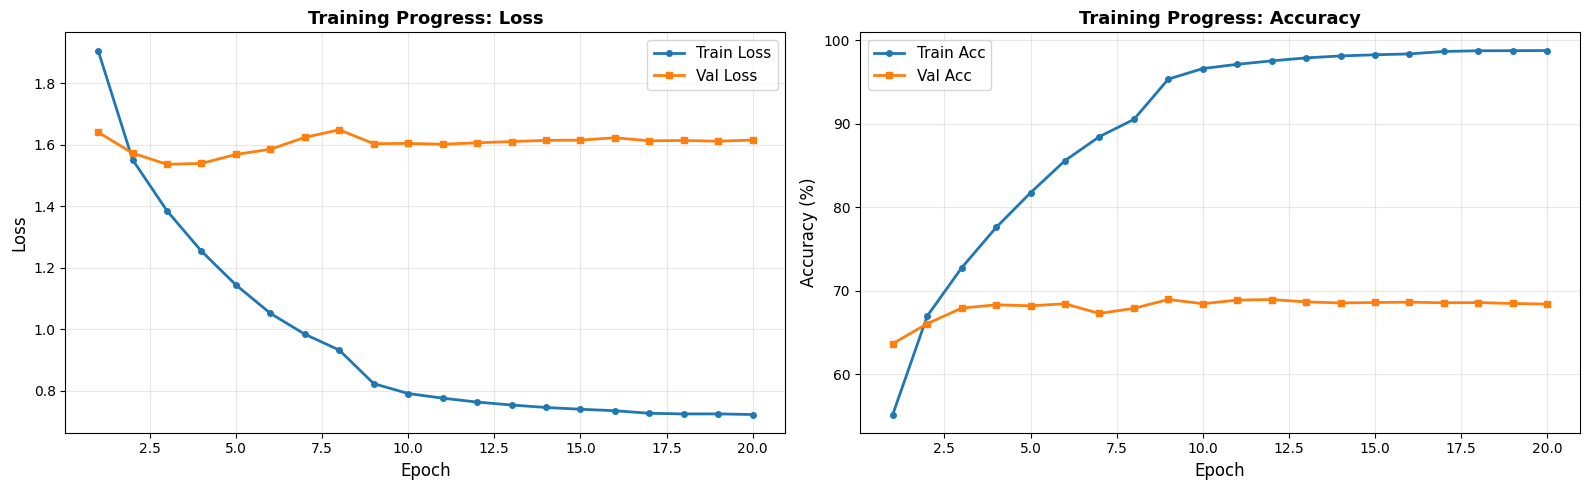


📊 Best Val Acc: 68.94% | Best Val F1: 0.6857

🎉 TRAINING COMPLETE
Best Epoch: 9
Best Val Accuracy: 68.94%
Best Val F1 Score: 0.6857
Best Val Loss: 1.6034
✅ Metrics saved to: /workspace/checkpoints/resnet50_production/training_metrics.json


PosixPath('/workspace/checkpoints/resnet50_production/training_metrics.json')

In [11]:
print("=" * 80)
print("HIGH-SCORE TRAINING CONFIGURATION")
print("=" * 80)
print("Strategy: Adam + ReduceLROnPlateau + Light Augmentation")
print(f"Optimizer: Adam (lr=1e-4)")
print(f"Scheduler: ReduceLROnPlateau (mode='max', factor=0.1, patience=3)")
print(f"Epochs: 20")
print(f"Model: ResNet50 (freeze_backbone=False - train all layers)")
print("=" * 80 + "\n")

# Initialize optimizer and scheduler (High-Score Configuration)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',      # Monitor validation metric (maximize)
    factor=0.1,      # Reduce LR by 10x
    patience=3,      # Wait 3 epochs before reducing
    verbose=True
)

# Training history
history = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": [],
    "learning_rate": []
}

best_val_acc = 0.0
best_val_f1 = 0.0
best_val_loss = float('inf')
best_epoch = 0

num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*80}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # =========================================================================
    # TRAINING PHASE
    # =========================================================================
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    all_train_preds = []
    all_train_labels = []
    
    train_pbar = tqdm(train_loader, desc=f"Training", ncols=100)
    for batch_idx, (images, labels) in enumerate(train_pbar):
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        optimizer.zero_grad()
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        # Metrics
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Collect for F1 score
        all_train_preds.extend(predictions.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
        
        # Batch-level wandb logging
        wandb.log({
            "batch_train_loss": loss.item(),
            "batch_train_acc": 100.0 * (predictions == labels).sum().item() / labels.size(0),
            "global_step": epoch * len(train_loader) + batch_idx
        })
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * train_correct / train_total:.2f}%'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * train_correct / train_total
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    
    # =========================================================================
    # VALIDATION PHASE
    # =========================================================================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_labels = []
    
    val_pbar = tqdm(val_loader, desc="Validation", ncols=100)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
            
            if CONFIG["use_amp"]:
                with torch.amp.autocast(device_type="cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            # Collect for F1 score
            all_val_preds.extend(predictions.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * val_correct / val_total:.2f}%'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    
    # =========================================================================
    # UPDATE HISTORY & LOGGING
    # =========================================================================
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_accuracy)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_accuracy)
    history["val_f1"].append(val_f1)
    history["learning_rate"].append(optimizer.param_groups[0]['lr'])
    
    # Epoch-level wandb logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_acc": train_accuracy,
        "train_f1": train_f1,
        "val_loss": avg_val_loss,
        "val_acc": val_accuracy,
        "val_f1": val_f1,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    # Print epoch summary
    print(f"\n{'─'*80}")
    print(f"📊 Epoch {epoch + 1} Summary:")
    print(f"{'─'*80}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_accuracy:.2f}% | Val F1:   {val_f1:.4f}")
    print(f"{'─'*80}")
    
    # =========================================================================
    # MODEL CHECKPOINTING
    # =========================================================================
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_f1 = val_f1
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        
        checkpoint_path = CONFIG["checkpoint_dir"] / "best_model.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if CONFIG["use_amp"] else None,
            'val_acc': val_accuracy,
            'val_loss': avg_val_loss,
            'val_f1': val_f1,
            'train_acc': train_accuracy,
            'train_loss': avg_train_loss,
            'train_f1': train_f1,
            'history': history
        }, checkpoint_path)
        
        print(f"✅ New best model saved! (Val Acc: {val_accuracy:.2f}%, Val F1: {val_f1:.4f})")
    
    scheduler.step(val_f1)  # Monitor validation F1 score
    
    update_plots()

print("\n" + "=" * 80)
print("🎉 TRAINING COMPLETE")
print("=" * 80)
print(f"Best Epoch: {best_epoch}")
print(f"Best Val Accuracy: {best_val_acc:.2f}%")
print(f"Best Val F1 Score: {best_val_f1:.4f}")
print(f"Best Val Loss: {best_val_loss:.4f}")
print("=" * 80)

# Save metrics to JSON
def save_metrics_to_json(history, checkpoint_dir, filename="training_metrics.json"):
    """Save training metrics to JSON file."""
    metrics = {
        "training_history": history,
        "best_metrics": {
            "epoch": best_epoch,
            "val_acc": best_val_acc,
            "val_f1": best_val_f1,
            "val_loss": best_val_loss
        },
        "config": {
            "optimizer": "Adam",
            "learning_rate": 1e-4,
            "scheduler": "ReduceLROnPlateau",
            "epochs": num_epochs,
            "batch_size": CONFIG["batch_size"],
            "image_size": CONFIG["img_size"]
        }
    }
    
    output_path = checkpoint_dir / filename
    with open(output_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print(f"✅ Metrics saved to: {output_path}")
    return output_path

# Call the save function
save_metrics_to_json(history, CONFIG["checkpoint_dir"])

## 5. Final Evaluation

In [12]:
checkpoint = torch.load(CONFIG["checkpoint_dir"] / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Best model from epoch {checkpoint['epoch']}")
print(f"Val Accuracy: {checkpoint['val_acc']:.2f}%")

Best model from epoch 9
Val Accuracy: 68.94%


In [13]:
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
        else:
            outputs = model(images)
            
        predictions = torch.argmax(outputs, dim=-1)
        all_preds_val.extend(predictions.cpu().numpy())
        all_labels_val.extend(labels.numpy())

val_acc_final = accuracy_score(all_preds_val, all_labels_val)
print(f"Validation Accuracy: {val_acc_final*100:.2f}%")

Validation: 100%|██████████| 170/170 [00:09<00:00, 17.22it/s]

Validation Accuracy: 68.94%


In [14]:
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Hold-out Test"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
        else:
            outputs = model(images)
            
        predictions = torch.argmax(outputs, dim=-1)
        all_preds_test.extend(predictions.cpu().numpy())
        all_labels_test.extend(labels.numpy())

test_acc_final = accuracy_score(all_labels_test, all_preds_test)
print(f"Hold-out Test Accuracy: {test_acc_final*100:.2f}%")

print("\n" + "=" * 80)
print("Classification Report (Hold-out Test)")
print("=" * 80)
print(classification_report(all_labels_test, all_preds_test, digits=4, zero_division=0))

Hold-out Test: 100%|██████████| 200/200 [00:12<00:00, 16.12it/s]

Hold-out Test Accuracy: 68.42%

Classification Report (Hold-out Test)
              precision    recall  f1-score   support

           0     0.5685    0.6574    0.6097       467
           1     0.6588    0.6676    0.6631       376
           2     0.5783    0.5278    0.5519       252
           3     0.7321    0.6560    0.6920       125
           4     0.6592    0.6608    0.6600       401
           5     0.9241    0.9444    0.9341       593
           6     0.6548    0.4783    0.5528       115
           7     0.4288    0.4077    0.4180       731
           8     0.3359    0.2797    0.3053       311
           9     0.7216    0.7979    0.7578       757
          10     0.8762    0.7603    0.8142       121
          11     0.5207    0.5053    0.5129       374
          12     0.6280    0.5350    0.5778       486
          13     0.6356    0.5913    0.6127       761
          14     0.8090    0.8328    0.8207       646
          15     0.7295    0.7417    0.7355       120
          1

In [15]:
history_path = CONFIG["checkpoint_dir"] / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

results = {
    "best_epoch": int(checkpoint['epoch']),
    "val_acc": float(checkpoint['val_acc']),
    "final_val_acc": float(val_acc_final * 100),
    "final_test_acc": float(test_acc_final * 100),
    "num_classes": int(num_classes),
    "model": "ResNet50"
}

results_path = CONFIG["checkpoint_dir"] / "final_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"History saved: {history_path}")
print(f"Results saved: {results_path}")

History saved: /workspace/checkpoints/resnet50_production/training_history.json
Results saved: /workspace/checkpoints/resnet50_production/final_results.json


## 6. Visualizations

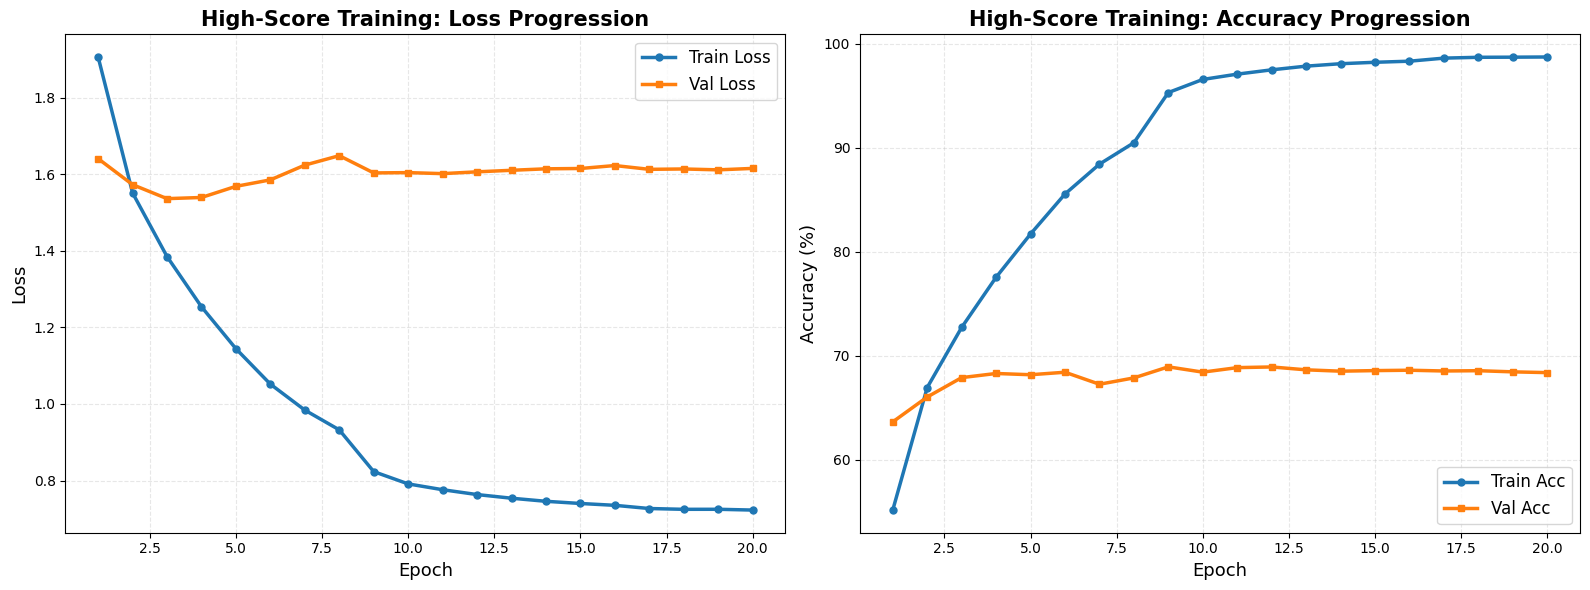

✓ Training curves saved: /workspace/checkpoints/resnet50_production/training_curves_highscore.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs = list(range(1, len(history["train_loss"]) + 1))

# Plot Loss
axes[0].plot(epochs, history["train_loss"], label='Train Loss', marker='o', linewidth=2.5, markersize=5)
axes[0].plot(epochs, history["val_loss"], label='Val Loss', marker='s', linewidth=2.5, markersize=5)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Loss', fontsize=13)
axes[0].set_title('High-Score Training: Loss Progression', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=12, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Plot Accuracy
axes[1].plot(epochs, history["train_acc"], label='Train Acc', marker='o', linewidth=2.5, markersize=5)
axes[1].plot(epochs, history["val_acc"], label='Val Acc', marker='s', linewidth=2.5, markersize=5)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Accuracy (%)', fontsize=13)
axes[1].set_title('High-Score Training: Accuracy Progression', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=12, loc='lower right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plot_path = CONFIG["checkpoint_dir"] / 'training_curves_highscore.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved: {plot_path}")

## 7. Summary

In [17]:
print("=" * 80)
print("Training Summary")
print("=" * 80)
print(f"Model: ResNet50")
print(f"Total samples: {len(df_train) + len(df_val) + len(df_holdout):,}")
print(f"Training: {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")
print(f"Hold-out: {len(test_dataset):,}")
print(f"Classes: {num_classes}")
print(f"\nBest epoch: {checkpoint['epoch']}")
print(f"Best val accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Final val accuracy: {val_acc_final*100:.2f}%")
print(f"Final test accuracy: {test_acc_final*100:.2f}%")
print("=" * 80)

wandb.finish()

Training Summary
Model: ResNet50
Total samples: 84,916
Training: 61,351
Validation: 10,827
Hold-out: 12,738
Classes: 27

Best epoch: 9
Best val accuracy: 68.94%
Final val accuracy: 68.94%
Final test accuracy: 68.42%


batch_train_acc,▁▂▂▄▂▄▆▂▄▆▅▅▆▇▅▇█████▇██▇██████████▇▇███
batch_train_loss,█▇▇▇▆▄▃▃▄▄▃▃▂▃▃▃▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███████
learning_rate,████████▂▂▂▂▂▂▂▂▁▁▁▁
train_acc,▁▃▄▅▅▆▆▇▇███████████
train_f1,▁▃▄▅▅▆▆▇▇███████████
train_loss,█▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▇▇▇▇▆▇█▇███▇██▇█▇▇
val_f1,▁▄▆█▇▇▆▇█▇███▇▇███▇▇
+1,...
